In [4]:
import sys
sys.path.append('/Users/charleshiggins/Personal/CharlesPhD/CodeRepo/xai_intervention/RL-LRP/')


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb
from experiments import DiffLrpWrapper, SimpleRNet, apply_threshold
from experiments import CosineDistanceLoss, ManualCNN
from matplotlib import pyplot as plt
import numpy as np
# Load and transform the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Initialize the network and optimizer for the underlying network


data, target = next(iter(test_loader))
# model = DiffLrpWrapper(SimpleRNet())
model = ManualCNN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# now wrap the network in the LRP class
# wrapped_model = DiffLrpWrapper(model)
criterion = CosineDistanceLoss()

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# over_train_data, over_train_target = data[:1,:,:,:], target[:1]  # Get a single image and target
# # expand so we repeat the same input to a batch size of 64
# over_train_data, over_train_target = over_train_data.expand(64, 1, 28, 28), over_train_target.expand(64)

model.train()
for x in range(1000):
    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)
    target_map = apply_threshold(data, threshold=0.99)
    optimizer.zero_grad()
    # print(target.unsqueeze(1))
    output = model(data)
    # print(output.shape, target_map.shape) 
    loss = criterion(output, target_map)
    loss.backward()
    optimizer.step()
    
    if x % 10 == 0:
        print(f'Train Epoch: [{x * len(data)}/{len(train_loader.dataset)} ({100. * x / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    if x % 50 == 0:
        # Plotting
        num = np.random.randint(0, 64)
        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(output[num][0].detach().numpy(), cmap='hot')
        axes[0].set_title(f'LRP Output after {x} iterations')
        axes[1].imshow(target_map[num][0], cmap='hot')
        axes[1].set_title('Original Image')
        plt.show()
    


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from contextlib import contextmanager
from experiments import reverse_layer, diff_softmax

/Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [52]:
# Define a simple neural network with explicit activation functions
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(8000, 50) #make sure to switch to 320 for maxpooling
        self.fc2 = nn.Linear(50, 10)
        
    # Simple forward pass without maxpooling for the PoC 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # print(f"shape before")
        # print(x.shape)
        x = x.view(-1, 20*20*20)
        # print(f"shape after: {x.shape}")
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        # return F.log_softmax(x, dim=1)
            
    # def forward(self, x):
    #     x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    #     x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    #     print(f"shape before")
    #     print(x.shape)
    #     x = x.view(-1, 320)
    #     print(f"shape after: {x.shape}")
    #     x = F.relu(self.fc1(x))
    #     x = self.fc2(x)
    #     return F.log_softmax(x, dim=1)

In [53]:

# Define a context manager to track activations
@contextmanager
def track_activations(wrapper):
    original_relu = F.relu
    original_max_pool2d = F.max_pool2d
    original_log_softmax = F.log_softmax
    
    def wrapped_relu(input, *args, **kwargs):
        output = original_relu(input, *args, **kwargs)
        wrapper.record_activation('ReLU', input, output)
        return output
    
    def wrapped_max_pool2d(input, *args, **kwargs):
        output = original_max_pool2d(input, *args, **kwargs)
        wrapper.record_activation('MaxPool2d', input,output)
        return output
    
    def wrapped_log_softmax(input, *args, **kwargs):
        output = original_log_softmax(input, *args, **kwargs)
        wrapper.record_activation('LogSoftmax', input, output)
        return output
    
    F.relu = wrapped_relu
    F.max_pool2d = wrapped_max_pool2d
    F.log_softmax = wrapped_log_softmax
    
    try:
        yield
    finally:
        F.relu = original_relu
        F.max_pool2d = original_max_pool2d
        F.log_softmax = original_log_softmax


# Wrapper class to track layers and activations
class WrapperNet(nn.Module):
    def __init__(self, model):
        super(WrapperNet, self).__init__()
        self.model = model
        self.executed_layers = []
        self.activations_inputs = []
        self.activation_outputs = []
        
        # Register hooks for the layers
        for name, module in self.model.named_modules():
            if not isinstance(module, nn.Sequential) and not isinstance(module, WrapperNet) and not len(list(module.children())) > 0:
                module.register_forward_hook(self.forward_hook)
    
    def forward_hook(self, module, input, output):
        self.executed_layers.append((module.__class__.__name__, module))
        self.activations_inputs.append(input)
        self.activation_outputs.append(output)
    
    def record_activation(self, name, input, output):
        self.executed_layers.append(name)
        self.activations_inputs.append(input)
        self.activation_outputs.append(output)

    def forward(self, x):
        self.executed_layers = []
        self.activations_inputs = []
        self.activation_outputs = []
        with track_activations(self):
            y =  self.model(x)
        relevance = diff_softmax(y)
        for index, layer in enumerate(zip(reversed(self.executed_layers), reversed(self.activations_inputs), reversed(self.activation_outputs))):
            # print(f'Layer {index}: {layer[0]}')
            # print(relevance.shape, layer[2][0].shape)
            if relevance.shape != layer[2].shape:
                    # print(f"mis matching shapes: {relevance.shape} and {layer[2].shape}")
                    relevance = relevance.view(layer[2].shape)
                    # print(f"reshaped relevance: {relevance.shape}")
            if isinstance(layer[0], tuple):
                # if there is a reshaping operation, we need to reshape the relevance tensor
                relevance = reverse_layer(layer[1][0], layer[0][1], relevance)
            else:
                relevance = reverse_layer(layer[1], None, relevance, layer_type=layer[0])
        return relevance

    def get_layers_and_activation_lists(self):
        return self.executed_layers, self. activation_inputs, self.activation_outputs

# Instantiate the network
model = SimpleNet()
wrapped_model = WrapperNet(model)

# Create a sample input tensor
input_tensor = torch.randn(1, 1, 28, 28)

# Perform a forward pass
output = wrapped_model(input_tensor)

# Get the layers and activations
# layers, activations = wrapped_model.get_layers_and_activation_lists()

# print("Layers and activations executed in forward pass:", layers)
# print("Activation outputs:", activations)


In [54]:
# using this wrapper, an entry in in the list which is a tuple contains weights, anything that doesn't is an activation. 


Train Epoch: [0/60000 (0%)]	Loss: 1.079095


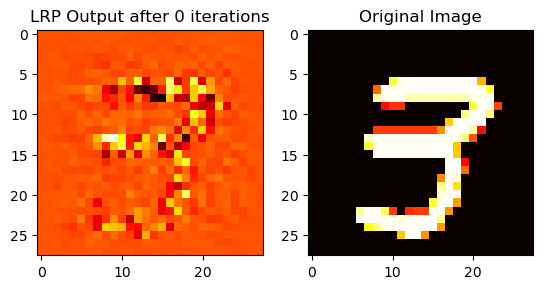

Train Epoch: [640/60000 (1%)]	Loss: 0.020329
Train Epoch: [1280/60000 (2%)]	Loss: 0.014326
Train Epoch: [1920/60000 (3%)]	Loss: 0.011256
Train Epoch: [2560/60000 (4%)]	Loss: 0.011069
Train Epoch: [3200/60000 (5%)]	Loss: 0.011004


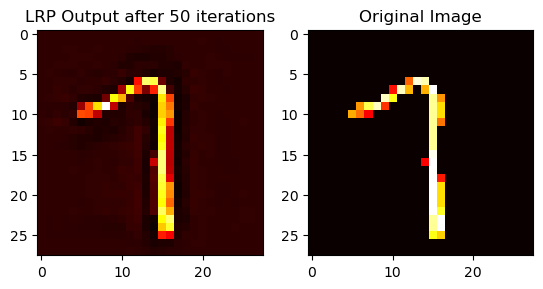

KeyboardInterrupt: 

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb
from experiments import DiffLrpWrapper, SimpleRNet, apply_threshold
from experiments import CosineDistanceLoss, ManualCNN
from matplotlib import pyplot as plt
import numpy as np
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Initialize the network and optimizer for the underlying network


data, target = next(iter(test_loader))
# model = DiffLrpWrapper(SimpleRNet())
model = WrapperNet(SimpleNet())
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# now wrap the network in the LRP class
# wrapped_model = DiffLrpWrapper(model)
criterion = CosineDistanceLoss()

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# over_train_data, over_train_target = data[:1,:,:,:], target[:1]  # Get a single image and target
# # expand so we repeat the same input to a batch size of 64
# over_train_data, over_train_target = over_train_data.expand(64, 1, 28, 28), over_train_target.expand(64)

model.train()
for x in range(1000):
    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)
    target_map = apply_threshold(data, threshold=0.99)
    optimizer.zero_grad()
    # print(target.unsqueeze(1))
    output = model(data)
    # print(output.shape, target_map.shape) 
    loss = criterion(output, target_map)
    loss.backward()
    optimizer.step()
    
    if x % 10 == 0:
        print(f'Train Epoch: [{x * len(data)}/{len(train_loader.dataset)} ({100. * x / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    if x % 50 == 0:
        # Plotting
        num = np.random.randint(0, 64)
        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(output[num][0].detach().numpy(), cmap='hot')
        axes[0].set_title(f'LRP Output after {x} iterations')
        axes[1].imshow(target_map[num][0], cmap='hot')
        axes[1].set_title('Original Image')
        plt.show()
    
